# What's in my gut? Comparing your *ubiome* data to public datasets

## Introduction

This notebook uses your *ubiome* data to visualise and compare your microbiome to other people's microbiome.

The analyses presented in this notebook are exploratory and only descriptive. Our microbiomes are not yet well understood, and are vastly different between people. Do not be suprised to see differ from the public ones!

## Data import

First, we load the necessary packages:

In [1]:
library(httr)
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats


The *ubiome* data is available as a raw fastq file or a json result file  
The fastq files are the "raw" data that contain the DNA sequences from a bacterial gene called "16S". While we could analyse those files and retrieve the bacterial composition of your samples, we will rather use the json file, which contains the result, as analysed by *ubiome*

We are not interested in the names of the users, so let's "anonimize" our dataframe first by dropping some columns

In [9]:
# download the public data and store in a data_frame
url <- paste0("https://www.openhumans.org/api/",
             "public-data/?source=direct-sharing-132")
resp <- GET(url)
results <- content(resp, as = "parsed", type = "application/json")$results
results <- bind_rows(lapply(results, as.data.frame.list, stringsAsFactors=FALSE))
jsons  <- filter(results, metadata.tags..json. == 'json') %>%
    select(-metadata.tags..fastq., -user.name, -user.username,
          -metadata.tags..uBiome., -metadata.tags..16S.,
          -source, -metadata.description, -metadata.tags..json.)
head(jsons)

id,basename,created,download_url,user.id,metadata.user_notes
37844,taxonomy.json,2018-04-10T19:21:12.089631Z,https://www.openhumans.org/data-management/datafile-download/37844/,08868768,NA
37870,taxonomy-1.json,2018-04-10T19:21:42.698608Z,https://www.openhumans.org/data-management/datafile-download/37870/,35269294,GENITAL (F) Sampled on 12/03/2015 Kit No. 407-018-198 Registered on 12/03/2015
37872,taxonomy-2.json,2018-04-10T19:21:42.709555Z,https://www.openhumans.org/data-management/datafile-download/37872/,35269294,GENITAL (F) Sampled on 5/09/2016 Kit No. 620-054-275 Registered on 5/10/2016
37874,taxonomy-3.json,2018-04-10T19:21:42.723138Z,https://www.openhumans.org/data-management/datafile-download/37874/,35269294,SKIN Sampled on 5/09/2016 Kit No. 620-054-275 Registered on 5/10/2016 EXPLORE SAMPLE
37876,taxonomy-4.json,2018-04-10T19:21:42.734174Z,https://www.openhumans.org/data-management/datafile-download/37876/,35269294,MOUTH SET DATE Kit No. 938-066-987 Registered on 7/31/2016
37878,taxonomy-5.json,2018-04-10T19:21:42.746854Z,https://www.openhumans.org/data-management/datafile-download/37878/,35269294,GUT SET DATE Kit No. 938-066-987 Registered on 7/31/2016


Now that we have a data frame containing all the public json files, we will read them and combine them in a data frame.

The block below defines a function that parses our data files, and the block below the function applies said function to all the public datasets.  
*Note: the data is quite messy and applying the cuntion will generate several warnings. You can probably ignore them.*

In [7]:
# this function assumes a valid data format and fails on unquoted json.
read_json_or_tbl_or_csv <- function(data_file) {
    tryCatch({
        jsonlite::fromJSON(data_file)$ubiome_bacteriacounts %>%
            select(taxon, parent, tax_name, tax_rank, count, count_norm) %>%
            mutate(id = strsplit(basename(data_file), ".", fixed = TRUE)[[1]][1])
        },
        error = function(cond) {
            paste(cond)
            tryCatch({
                tab  <- read_table2(data_file) %>%
                    select(taxon, parent, tax_name, tax_rank, count, count_norm) %>%
                    mutate(id = strsplit(basename(data_file), ".", fixed = TRUE)[[1]][1])
                assertthat::assert_that(ncol(tab) > 1)
                return(tab)
                },
                error = function(bla) {
                    paste(bla)
                    csv <- read_csv(data_file) %>%
                        select(taxon, parent, tax_name, tax_rank, count, count_norm) %>%
                        mutate(id = strsplit(basename(data_file), ".", fixed = TRUE)[[1]][1])
                    return(csv)
                })
        }     
    )}

In [10]:
invisible(map2(jsons$download_url, paste0("data/", jsons$id, ".json"), download.file))
file.remove("data/37844.json")  # invalid json
data_path <- dir("data", pattern = '.json', full.names = TRUE)
data_container <- map(data_path, read_json_or_tbl_or_csv)
full_data <- map(data_container, mutate_all, as.character) %>%
    bind_rows()

[1] TRUE

Parsed with column specification:
cols(
  tax_name = col_character(),
  tax_rank = col_character(),
  count = col_character(),
  count_norm = col_character(),
  taxon = col_character(),
  parent = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“90 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file              expected   <int> <chr> <chr>     <chr>     <chr>             actual 1     5 <NA>  6 columns 7 columns 'data/37852.json' file 2    11 <NA>  6 columns 7 columns 'data/37852.json' row 3    14 <NA>  6 columns 7 columns 'data/37852.json' col 4    15 <NA>  6 columns 7 columns 'data/37852.json' expected 5    16 <NA>  6 columns 7 columns 'data/37852.json'
... ................. ... ................................................... ........ ................................................... ...... ...................................................

”Parsed with column specification:
cols(
  tax_name = col_character(),
  tax_rank = col_character(),
  count = col_character(),
  count_norm = col_character(),
  taxon = col_character(),
  parent = col_character()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“87 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file              expected   <int> <chr> <chr>     <chr>     <chr>             actual 1     7 <NA>  6 columns 7 columns 'data/37882.json' file 2     8 <NA>  6 columns 7 columns 'data/37882.json' row 3     9 <NA>  6 columns 7 columns 'data/37882.json' col 4    11 <NA>  6 columns 7 columns 'data/37882.json' expected 5    20 <NA>  6 columns 7 columns 'data/37882.json'
... ................. ... ................................................... ........ ................................................... ...... ..................................................

Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“92 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file              expected   <int> <chr> <chr>     <chr>     <chr>             actual 1    11 <NA>  6 columns 7 columns 'data/37914.json' file 2    12 <NA>  6 columns 7 columns 'data/37914.json' row 3    13 <NA>  6 columns 7 columns 'data/37914.json' col 4    17 <NA>  6 columns 7 columns 'data/37914.json' expected 5    24 <NA>  6 columns 7 columns 'data/37914.json'
... ................. ... ................................................... ........ ................................................... ...... ................................................... .... ................................................... ... ................................................... ... ................................................... ........ ....................................

In [11]:
head(full_data)

taxon,parent,tax_name,tax_rank,count,count_norm,id
1,0,root,root,82710,1000024,37852
2,131567,Bacteria,superkingdom,82708,1000000,37852
481,206351,Neisseriaceae,family,2,24,37852
482,481,Neisseria,genus,2,24,37852
24,496,Neisseria,macacae,species,2,37852
543,91347,Enterobacteriaceae,family,853,10313,37852


Now we download our own private microbiome data. Once again, you can safely ingore the warnings.

In [12]:
# now our private data
access_token <- Sys.getenv("OH_ACCESS_TOKEN")
url <- paste(
    "https://www.openhumans.org/api/direct-sharing/",
    "project/exchange-member/?access_token=",
    access_token, sep="")
resp <- GET(url)
user <- content(resp, "parsed")
my_files  <- c()
for (data_source in user$data){
    if (data_source$source == "direct-sharing-132"){
        my_files <- c(my_files, data_source$download_url)
    }
}
my_files <- subset(my_files, grepl("json", my_files))
download.file(my_files, destfile = "data/my_microbiome.json")

In [19]:
my_data <- read_json_or_tbl_or_csv("data/my_microbiome.json") %>%
    mutate_all(as.character)

Parsed with column specification:
cols(
  tax_name = col_character(),
  tax_rank = col_character(),
  count = col_character(),
  count_norm = col_integer(),
  taxon = col_integer(),
  parent = col_integer()
)
Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“20 parsing failures.
row # A tibble: 5 x 5 col     row col   expected  actual    file                      expected   <int> <chr> <chr>     <chr>     <chr>                     actual 1     5 <NA>  6 columns 7 columns 'data/my_microbiome.json' file 2    11 <NA>  6 columns 7 columns 'data/my_microbiome.json' row 3    14 <NA>  6 columns 7 columns 'data/my_microbiome.json' col 4    15 <NA>  6 columns 7 columns 'data/my_microbiome.json' expected 5    16 <NA>  6 columns 7 columns 'data/my_microbiome.json'
... ................. ... ........................................................... ........ ....................................................

## Exploratory analysis

We have loaded the datasets! Now we can compare our microbiome data to others'

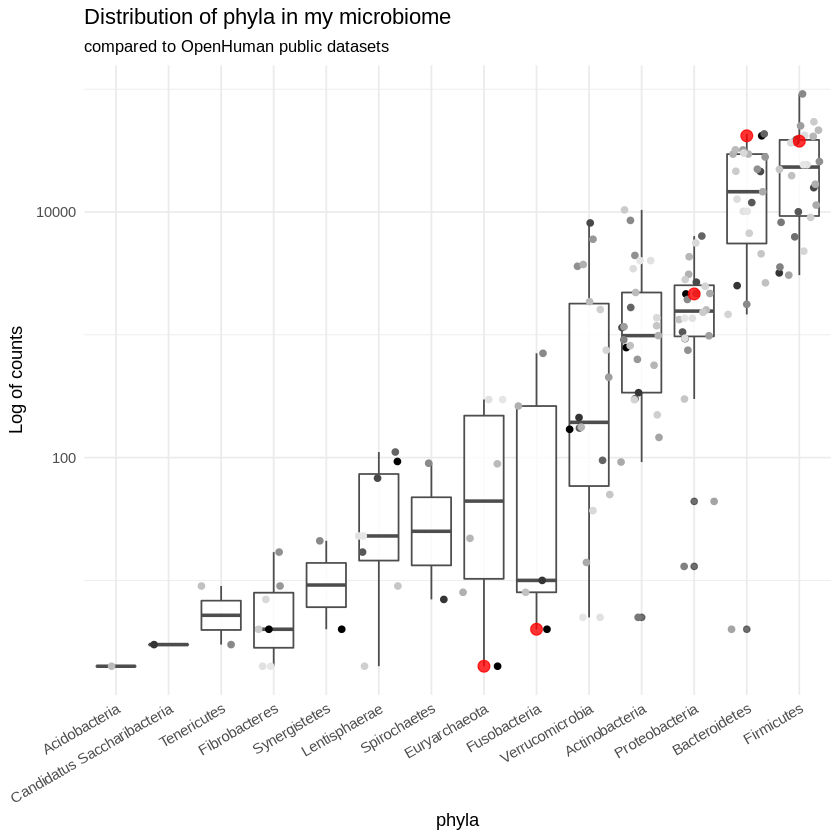

In [20]:
phyla <- full_data %>% filter(tax_rank == "phylum")

ggplot(phyla) +
    geom_boxplot(aes(reorder(tax_name, as.numeric(count)), as.numeric(count)), alpha = 0.8, colour = "grey30") +
    geom_jitter(aes(reorder(tax_name, as.numeric(count)), as.numeric(count), colour = id)) +
    scale_colour_grey(start = 0, end = .9) +
    geom_point(data = filter(my_data, tax_rank == "phylum"),
               aes(reorder(tax_name, as.numeric(count)), as.numeric(count)), colour = "red",
               size = 3, alpha = 0.8) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 30, hjust = 1),
         legend.position = "none") +
    ggtitle("Distribution of phyla in my microbiome",
           subtitle = "compared to OpenHuman public datasets") +
    xlab("phyla") +
    ylab("Log of counts") +
    scale_y_log10()

This plot represents the log of the bacteria counts for each phyla found in the samples. Public data is in grey, you are in red!

The public datasets are mostly from gut samples. If you see outlier in grey, they may come from genital or skin samples. 

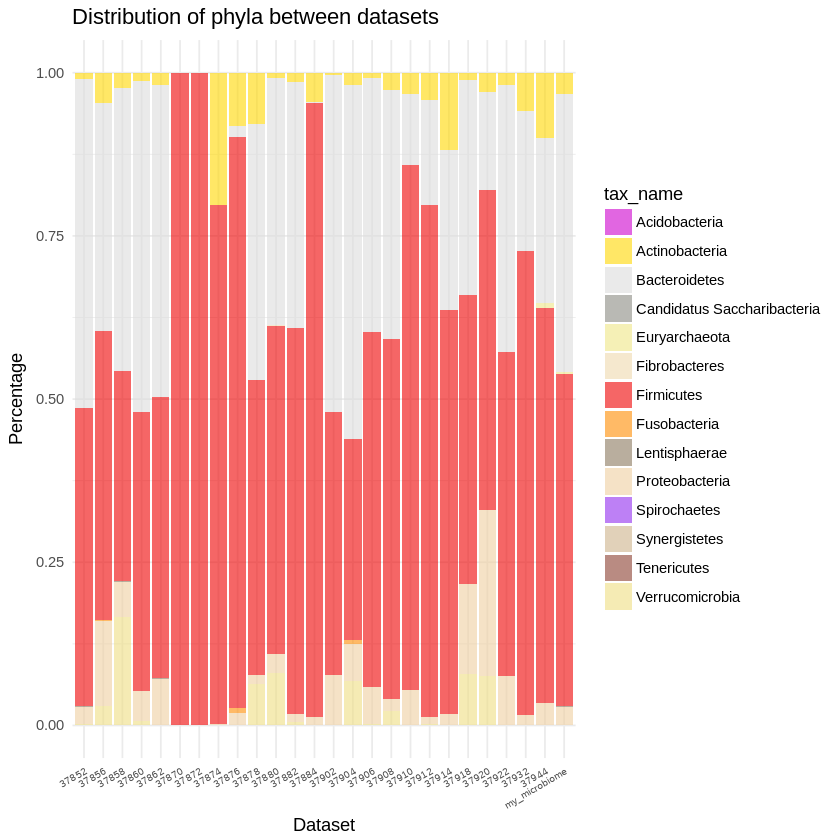

In [21]:
# merge both datasets for the stacked bar chart
data_4_barchart  <- bind_rows(full_data, my_data) %>%
    filter(tax_rank == "phylum")

# random color scale up to 433 colors
n <- distinct(data_4_barchart, tax_name)
color <- grDevices::colors()[grep('gr(a|e)y', grDevices::colors(), invert = T)]
col <- sample(color, length(n$tax_name))

ggplot(data_4_barchart) +
    geom_bar(aes(id, as.numeric(count), fill = tax_name),
             stat = 'identity', position = 'fill', alpha = 0.6) +
    ggtitle("Distribution of phyla between datasets") +
    theme_minimal() +
    scale_fill_manual(values = col) +
    theme(axis.text.x = element_text(angle = 30, hjust = 1, size = 6)) +
    xlab("Dataset") +
    ylab("Percentage")